In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import *
from scipy.stats import norm,kstest,shapiro,t
import warnings
import seaborn as sns
import statsmodels.api as sm
import statistics
warnings.filterwarnings('ignore')
import os
lib_path = os.path.join(os.path.abspath('.'), '..')
sys.path.append(lib_path)
from risk_management import *
from tabulate import tabulate
# Import plotly express for EF plot
import plotly.express as px
px.defaults.template = "plotly_dark"
px.defaults.width = 1000
px.defaults.height = 600
import scipy.optimize as sco

/Users/zesheng.li/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/zesheng.li/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


## Problem 1

- Current Stock Price 165
- Strike Price 165 
- Current Date 03/13/2022 
- Options Expiration Date 04/15/2022 
- Risk Free Rate of 0.25% 
- Continuously Compounding Coupon of 0.53%

In [2]:

current = datetime(2022,3,13)
expiration = datetime(2022,4,15)
TTM = (expiration-current).days

S = 165
K = 165
T = TTM/365
r = 0.25/100
q = 0.53/100
sigma = 0.2

In [3]:
def black_scholes(S,K,T,r,q,sigma,call=True):
    d1 = (np.log(S/K)+(r-q+sigma**2/2)*T)/(sigma*np.sqrt(T))
    d2 = d1-sigma*np.sqrt(T)
    if call==True:
        return S*np.exp(-q*T)*norm.cdf(d1)-K*np.exp(-r*T)*norm.cdf(d2)
    else:
        return K*np.exp(-r*T)*norm.cdf(-d2)-S*np.exp(-q*T)*norm.cdf(-d1)

- Delta : Measures Impact of a Change in the Price of Underlying ($1)
- Gamma: Measures the Rate of Change of Delta (1 Delta)
- Theta: Measures Impact of a Change in Time Remaining (1 day)
- Vega: Measures Impact of a Change in Volatility (1% vol)
- Rho: Measures the impact of changes in Interest rates (1% rate)

In [4]:
from risk_management.blackscholes import BSOption,FDOption,BinomialTreeOption,BinomialTree
bscall = BSOption(S, K, T, r, q, sigma, call=True).Greek
bsput = BSOption(S, K, T, r, q, sigma, call=False).Greek
fdcall = FDOption(S, K, T, r, q, sigma, call=True).Greek
fdput = FDOption(S, K, T, r, q, sigma, call=False).Greek


allgreek = pd.concat([bscall,bsput,fdcall,fdput],axis=1)
allgreek

,GBSM Call,GBSM Put,Finite Diff Call,Finite Diff Put
delta,0.510071,-0.489450,0.510071,-0.489450
gamma,0.040173,0.040173,0.040173,0.040173
vega,0.197766,0.197766,0.197766,0.197766
theta,-0.059256,-0.060571,-0.059257,-0.060522
rho,0.072533,-0.076611,0.072533,-0.076611
phi,-0.076091,0.073015,-0.076091,0.073015


In [5]:
BSOption(S, K, T, r, q, sigma, call=True).Price

3.935701257793056

## Conclusion 1.1

- Delta : Measures Impact of a Change in the Price of Underlying
- Gamma: Measures the Rate of Change of Delta
- Theta: Measures Impact of a Change in Time Remaining
- Vega: Measures Impact of a Change in Volatility
- Rho: Measures the impact of changes in Interest rates
- Phi: Measures the impact of dividen rate changes

Because black scholes is a stochastic differential equation, the formula can be used to derive the most accurate Greek. But there are a lot of SDE that don't have analytic solutions and if still want to derive the sensitivity of option prices, I have to use the finite difference method. Finite-difference method derivative calculation can also approximate real Greek when the changes of impact is small enough.

## Conclusion 1.2
The Binomial Tree option price and Greek:

In [6]:
DivTime = (datetime(2022,4,11)-datetime(2022,3,13)).days/365
div=[[DivTime],[1]]
divCall = BinomialTree('C', 165, 165, r, sigma, T, 2000, 'true', div)
divPut = BinomialTree('P', 165, 165, r, sigma, T, 2000, 'true', div)
#print(f"The American call option price is {round(divCall,4)}, and its put option price is {round(divPut,4)}." )
table = [[divCall, divPut]]
header = ['American Call','American Put']
print(tabulate(table,headers=header))

  American Call    American Put
---------------  --------------
        3.81468         4.44687


In [7]:
BTCall = BinomialTreeOption('C', 165, 165, r, sigma, T, 2000,'true', div).Greek
BTPut = BinomialTreeOption('P', 165, 165, r, sigma, T, 2000,'true', div).Greek
Greek3Opt = pd.concat([BTCall,BTPut],axis=1)
np.around(Greek3Opt,6)

,Binomial Tree Call,Binomial Tree Put
delta,0.510500,-0.531187
gamma,0.041285,0.039790
vega,0.193492,0.196076
theta,-0.036782,-0.058981
rho,0.065389,-0.077462
dividen sensitivity,-0.095796,0.531082


## Conclusion 1.3
The sensitivity of put and call to a change of dividend amount shows in the above table. When dividen rises `$`1, the price of American call option will decrease `$`0.0958 and put price will go up `$`0.5311

## Problem2
Using the options portfolios from Problem3 last week (named problem2.csv in this week’s repo) and assuming :

- American Options
- Current Date 02/25/2022 
- Current AAPL price is 164.85
- Risk Free Rate of 0.25% 
- Dividend Payment of 1.00 on 3/15/2022

Using DailyReturn.csv. Fit a Normal distribution to AAPL returns – assume 0 mean return. Simulate AAPL returns 10 days ahead and apply those returns to the current AAPL price (above). Calculate Mean, VaR and ES.

In [8]:
S = 164.85
r = 0.25/100
DivTime = (datetime(2022,3,15)-datetime(2022,2,25)).days/365
port = pd.read_csv('problem2.csv')
port

,Portfolio,Type,Underlying,Holding,OptionType,ExpirationDate,Strike,CurrentPrice
0,Straddle,Option,AAPL,1,Call,3/18/2022,165.0,4.50
1,Straddle,Option,AAPL,1,Put,3/18/2022,165.0,4.40
2,SynLong,Option,AAPL,1,Call,3/18/2022,165.0,4.50
3,SynLong,Option,AAPL,-1,Put,3/18/2022,165.0,4.40
4,CallSpread,Option,AAPL,1,Call,3/18/2022,165.0,4.50
5,CallSpread,Option,AAPL,-1,Call,3/18/2022,175.0,0.72
6,PutSpread,Option,AAPL,1,Put,3/18/2022,165.0,4.40
7,PutSpread,Option,AAPL,-1,Put,3/18/2022,155.0,1.60
8,Stock,Stock,AAPL,1,NaN,NaN,NaN,164.85
9,Call,Option,AAPL,1,Call,3/18/2022,165.0,4.50


In [9]:
returns = pd.read_csv('DailyReturn.csv',index_col = 0)
returns = returns['AAPL']
aaplSigma = returns.std()


In [10]:


T = (datetime(2022,3,18) - datetime(2022,2,25)).days/365

K = port['Strike']
Type = np.where((port['OptionType'] == "Call"), True, np.where((port['OptionType'] == "Put"), False, np.nan))
opt_price = port['CurrentPrice']


implied_vol = []
optDelta = []
for i in range(len(K)):
    if port['Type'][i]=='Option':
        implied_vol.append(blackscholes.implied_volatility(S,K[i],T,r,q,opt_price[i],Type[i]))
        
        opt = 'C' if port['OptionType'][i]=="Call" else 'P'
        div = [[DivTime],[0.88]]
        optDelta.append(BinomialTreeOption(opt, 164.85, port['Strike'][i], r, sigma, T, 2000,'true', div).Delta)
    else:
        implied_vol.append(np.nan)
        optDelta.append(1)
        


In [11]:
port['Implied vol'] = np.array(implied_vol)
port['Delta'] = np.array(optDelta)
port

,Portfolio,Type,Underlying,Holding,OptionType,ExpirationDate,Strike,CurrentPrice,Implied vol,Delta
0,Straddle,Option,AAPL,1,Call,3/18/2022,165.0,4.50,0.290819,0.508337
1,Straddle,Option,AAPL,1,Put,3/18/2022,165.0,4.40,0.273281,-0.533976
2,SynLong,Option,AAPL,1,Call,3/18/2022,165.0,4.50,0.290819,0.508337
3,SynLong,Option,AAPL,-1,Put,3/18/2022,165.0,4.40,0.273281,-0.533976
4,CallSpread,Option,AAPL,1,Call,3/18/2022,165.0,4.50,0.290819,0.508337
5,CallSpread,Option,AAPL,-1,Call,3/18/2022,175.0,0.72,0.236476,0.100589
6,PutSpread,Option,AAPL,1,Put,3/18/2022,165.0,4.40,0.273281,-0.533976
7,PutSpread,Option,AAPL,-1,Put,3/18/2022,155.0,1.60,0.331380,-0.112758
8,Stock,Stock,AAPL,1,NaN,NaN,NaN,164.85,NaN,1.000000
9,Call,Option,AAPL,1,Call,3/18/2022,165.0,4.50,0.290819,0.508337


#### Estimate the VaR and ES by using Delta-normal method
- we need calculate the gradient of each portfolio:
$$
\frac{dR}{dr_i} = \frac{P_i}{PV}\Sigma^m_{j=1}h_j\delta_j
$$

- for each portfolio, the volatility can be estimated by:
$$
\sigma_p = \nabla R^T \Sigma \nabla R
$$

- use the portfolio sigma to simulate 10000 draw of return series(assume the mean is 0)

- use historical data to calculate the VaR and ES

In [12]:
Strategy = port['Portfolio'].unique()
portGrad = []
Port_pv = []

for i in range(len(Strategy)):
    data = port[port['Portfolio']==Strategy[i]] 
    pv = (data['CurrentPrice']*data['Holding']).sum()
    Port_pv.append(pv)
    #print(port['Delta'])
    grad = S/pv * (data['Holding']*port['Delta']).sum()
    portGrad.append(grad)

portSigma = []
for grad in portGrad:
    portSigma.append(np.abs(grad)*aaplSigma)


In [13]:
# delta Normal
rets_sim = pd.DataFrame()
for i in range(len(portSigma)):
    return_simu = norm.rvs(size = 10000, loc=0, scale = portSigma[i]*np.sqrt(10))
    rets_sim[Strategy[i]] = return_simu
    

pred_mean = []
pred_VaR = []
pred_es = []
for i in range(len(Strategy)):
    sim_PnL = Port_pv[i]*(rets_sim[Strategy[i]])
    
    pred_mean.append(sim_PnL.mean())
    pred_VaR.append(VaR.VaR_Historic(sim_PnL))
    pred_es.append(ES.ES(sim_PnL))

In [14]:
stat = pd.DataFrame({"Mean":pred_mean,'VaR':pred_VaR,'ES':pred_es},index = Strategy)
stat

,Mean,VaR,ES
Straddle,0.000248,0.354497,0.439275
SynLong,-0.006445,14.355622,17.923193
CallSpread,-0.052434,5.555650,7.044779
PutSpread,0.076290,5.832645,7.273784
Stock,-0.058624,13.789824,17.429537
Call,-0.020548,6.991100,8.693729
Put,0.057560,7.262282,9.192509
CoveredCall,-0.005153,6.672733,8.396764
ProtectedPut,-0.055833,6.425375,8.052406



### Results from week06

<img src="last_week_stat.jpg" alt="drawing" width="350"/>

## Conclusion 2
The results estimated using Delta Normal are very similar to last week's results for most portfolio strategies, but since delta varies with option prices in nonlinear assets, huge deviation from correct result could occur  in the returns simulation of option portfolios.

## problem3

Use the Fama French 3 factor return time series (F-F_Research_Data_Factors_daily.CSV) as well as the Carhart Momentum time series (F-F_Momentum_Factor_daily.CSV) to fit a 4 factor model to the following stocks.

$$
R_s = R_f + \beta_1(Mkt-R_f) + \beta_2(SMB) + \beta_3(HML)
$$

In [15]:
# deal with the momentum data
ff_4th = pd.read_csv('F-F_Momentum_Factor_daily.CSV', parse_dates=['Date']).set_index('Date')/100
ff_4th.rename(columns = {'Mom   ':"Mom"},inplace=True)


In [16]:
rets = pd.read_csv('DailyReturn.csv', parse_dates=['Date']).set_index('Date')
rets.index = pd.DatetimeIndex(rets.index)


In [17]:
FF = pd.read_csv('F-F_Research_Data_Factors_daily.CSV')
FF['Date'] = FF['Date'].apply(lambda x: str(datetime.strptime(str(x), '%Y%m%d').date()))
FF.set_index('Date',inplace=True)
FF.index = pd.DatetimeIndex(FF.index)
FF /=100 #scale by div 100
FF = FF.join(ff_4th)
FF.tail()

,Mkt-RF,SMB,HML,RF,Mom
Date,,,,,
2022-01-25,-0.0143,-0.0060,0.0279,0.0,0.0026
2022-01-26,-0.0030,-0.0108,0.0009,0.0,0.0139
2022-01-27,-0.0078,-0.0163,0.0077,0.0,0.0030
2022-01-28,0.0245,-0.0015,-0.0207,0.0,-0.0027
2022-01-31,0.0233,0.0129,-0.0286,0.0,-0.0170


In [66]:
stockList = ['AAPL','FB','UNH','MA','MSFT','NVDA','HD','PFE','AMZN','BRK-B','PG','XOM','TSLA','JPM','V','DIS','GOOGL','JNJ','BAC','CSCO']
factors = ['Mkt-RF','SMB','HML','Mom']
fama_frame = rets.join(FF)
fama_frame.iloc[:,-10:].head()

,LMT,SYK,GM,TFC,TJX,Mkt-RF,SMB,HML,RF,Mom
Date,,,,,,,,,,
2021-10-21,0.005416,0.009789,0.012832,-0.004696,0.012841,0.0037,0.0020,-0.0098,0.0,0.0003
2021-10-22,0.003913,-0.002568,-0.010957,0.013526,-0.008040,-0.0025,-0.0023,0.0102,0.0,0.0031
2021-10-25,0.004618,-0.009720,-0.000173,0.002017,0.017145,0.0058,0.0049,-0.0016,0.0,0.0124
2021-10-26,-0.118035,0.000476,-0.006752,-0.002013,0.001073,0.0004,-0.0071,-0.0032,0.0,-0.0022
2021-10-27,-0.002922,-0.017132,-0.054210,-0.022191,-0.011786,-0.0076,-0.0074,-0.0119,0.0,-0.0008


In [67]:
param_dict = {}

x1 = fama_frame['Mkt-RF']
x2 = fama_frame['SMB']
x3 = fama_frame['HML']
x4 = fama_frame['Mom']

X = pd.DataFrame({"Mkt-RF":x1, "SMB":x2,"HML":x3,'Mom':x4})
X_ = sm.add_constant(X)
for st in stockList:
    Y = rets[st] - fama_frame['RF']
    result = sm.OLS(Y, X_).fit()
    param_dict[st] = (result.params)


## Conclusion 3.1
The expected annual geometric return and covariance of each stock:

In [105]:
FF_10years = FF[FF.index>=datetime(2012,1,31)]

exp_rets_frame = pd.DataFrame()

for st, param in param_dict.items():
    exp_rets = FF_10years[factors]@param[factors]+FF_10years['RF'].mean()
    exp_rets_frame[st] = exp_rets
stockMeans = np.log(1 + exp_rets_frame.mean())*255
covariance = np.log(rets[stockList] + 1).cov() * 255
stockMeans

AAPL     0.143414
FB       0.219205
UNH      0.137663
MA       0.261014
MSFT     0.172935
NVDA     0.325676
HD       0.100648
PFE     -0.150353
AMZN     0.186311
BRK-B    0.112803
PG       0.077017
XOM      0.179250
TSLA     0.184864
JPM      0.132777
V        0.190974
DIS      0.150065
GOOGL    0.194495
JNJ      0.075037
BAC      0.172139
CSCO     0.137953
dtype: float64

In [106]:
covariance

,AAPL,FB,UNH,MA,MSFT,NVDA,HD,PFE,AMZN,BRK-B,PG,XOM,TSLA,JPM,V,DIS,GOOGL,JNJ,BAC,CSCO
AAPL,0.065441,0.031073,0.020744,0.010865,0.039993,0.081306,0.020419,-0.021341,0.041714,0.000136,-0.002699,0.008210,0.081903,0.005251,0.010712,0.012826,0.031423,-0.003238,0.005305,0.011880
FB,0.031073,0.104613,0.008503,0.040435,0.037940,0.071235,0.007342,-0.034076,0.039219,0.009335,0.000548,0.016634,0.070407,0.003429,0.034626,0.029683,0.036417,0.005036,0.008607,0.016598
UNH,0.020744,0.008503,0.044678,0.025495,0.022884,0.037212,0.016155,-0.006501,0.018861,0.002269,0.011324,0.009566,0.024662,0.003660,0.018395,0.010282,0.021946,0.008787,0.003671,0.015559
MA,0.010865,0.040435,0.025495,0.129913,0.008331,0.032840,0.013766,-0.025942,0.018757,0.020274,0.012592,0.047964,0.042987,0.027444,0.098294,0.044054,0.010899,0.013416,0.040533,0.017995
MSFT,0.039993,0.037940,0.022884,0.008331,0.065237,0.089283,0.022864,-0.018821,0.033346,-0.001568,0.002797,0.004023,0.078434,-0.003993,0.003577,0.010030,0.051307,-0.001555,-0.000343,0.022863
NVDA,0.081306,0.071235,0.037212,0.032840,0.089283,0.354876,0.052871,-0.048652,0.100484,-0.003756,-0.009097,0.033804,0.188497,0.007134,0.041099,0.023697,0.083843,-0.013139,0.017036,0.013277
HD,0.020419,0.007342,0.016155,0.013766,0.022864,0.052871,0.058241,-0.022702,0.014528,0.000238,0.006162,0.005143,0.028978,0.014535,0.013316,0.011541,0.022639,0.002178,0.007904,0.003715
PFE,-0.021341,-0.034076,-0.006501,-0.025942,-0.018821,-0.048652,-0.022702,0.177019,-0.027410,-0.012057,0.005692,-0.036887,-0.055088,-0.022267,-0.015947,-0.023313,-0.021314,0.006779,-0.034283,-0.002152
AMZN,0.041714,0.039219,0.018861,0.018757,0.033346,0.100484,0.014528,-0.027410,0.066280,-0.001549,-0.003372,0.013645,0.041839,-0.001034,0.010257,0.017323,0.039699,-0.003340,0.002833,0.002798
BRK-B,0.000136,0.009335,0.002269,0.020274,-0.001568,-0.003756,0.000238,-0.012057,-0.001549,0.022978,0.009790,0.023074,-0.005053,0.022736,0.018162,0.010155,0.001378,0.009128,0.028815,0.007915


In [107]:
efport, tangency, assetWeight = effFrontier.effFrontier(stockMeans, covariance, scope=(0.01,0.3,100),rf=0.0025,shortValid = True)
tangency

ret       0.146135
vol       0.119725
sharpe    1.199701
dtype: float64

In [108]:
# Plot efficient frontier portfolio
fig = px.scatter(
    efport, x='targetvols', y='targetrets',  color='targetsharpe',
    labels={'targetrets': 'Expected Return', 'targetvols': 'Expected Volatility','targetsharpe': 'Sharpe Ratio'},
    title="Efficient Frontier Portfolio"
     ).update_traces(mode='markers', marker=dict(symbol='cross'))

# Plot maximum sharpe portfolio
fig.add_scatter(
    mode='markers',
    x=[tangency['vol']], 
    y=[tangency['ret']],
    marker=dict(color='red', size=20, symbol='star'),
    name = 'Max Sharpe'
).update(layout_showlegend=False)

# Show spikes
fig.update_xaxes(showspikes=True)
fig.update_yaxes(showspikes=True)
fig.show()

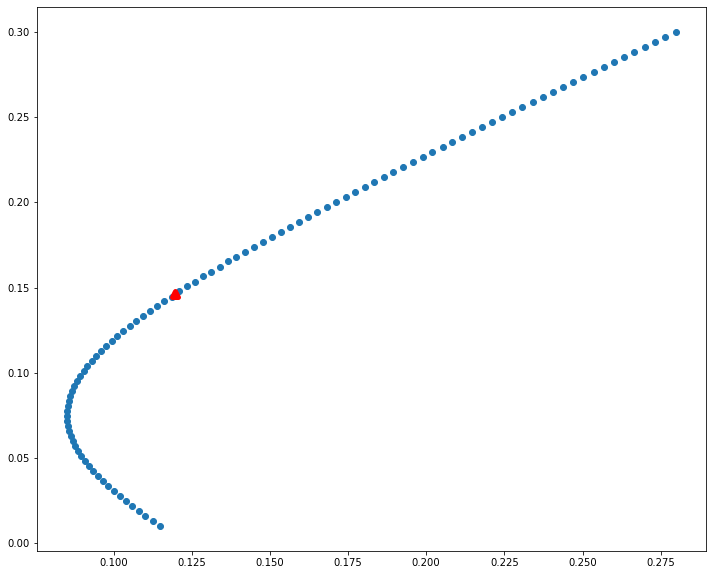

In [104]:
# show in the github
fig= plt.figure(figsize = (12,10))
plt.scatter(x=efport['targetvols'], y=efport['targetrets'])

plt.scatter(
    x=[tangency['vol']], 
    y=[tangency['ret']],color = 'red',linewidths=5,marker = '^'
)
fig.show()

In [42]:
round(assetWeight.T,4)

,AAPL,FB,UNH,MA,MSFT,NVDA,HD,PFE,AMZN,BRK-B,PG,XOM,TSLA,JPM,V,DIS,GOOGL,JNJ,BAC,CSCO
Weight,-0.0607,0.0145,0.0479,0.0882,0.0844,-0.0231,-0.0032,-0.0222,0.2546,0.2499,0.0087,-0.0145,-0.0045,0.0147,-0.016,0.0264,0.0394,0.1819,0.044,0.0897


## Conclusion 3.2
For the tangency portfolio, which is ths super efficient portfolio, we can invest each stock in the above weight. The expected annual return is 16.53%, volatility is 12.58% with 1.2948 sharpe ratio.